In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import talib #!pip install TA-lib | https://github.com/TA-Lib/ta-lib-python/issues/418

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import  GridSearchCV, HalvingGridSearchCV


In [2]:
# loading the data

prices = pd.read_csv("../data/stock_prices_yahoo.csv")

In [3]:
prices

,Unnamed: 0,index,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,0,0,2013-02-01,36.840000,37.200001,36.520000,37.180000,24.526785,9527500,ABBV
1,1,1,2013-02-04,36.639999,37.299999,36.549999,37.279999,24.592743,6348000,ABBV
2,2,2,2013-02-05,37.419998,37.730000,37.180000,37.200001,24.539970,7284400,ABBV
3,3,3,2013-02-06,36.959999,37.279999,36.860001,37.139999,24.500391,5738900,ABBV
4,4,4,2013-02-07,37.570000,37.570000,35.799999,36.419998,24.025429,9872500,ABBV
...,...,...,...,...,...,...,...,...,...,...
44091,44091,4608,2023-04-25,157.449997,158.550003,156.309998,157.229996,157.229996,143300,ROG
44092,44092,4609,2023-04-26,156.100006,157.320007,154.110001,154.539993,154.539993,139900,ROG
44093,44093,4610,2023-04-27,155.139999,156.270004,153.449997,155.600006,155.600006,106100,ROG
44094,44094,4611,2023-04-28,167.039993,167.039993,158.570007,160.949997,160.949997,305800,ROG


In [4]:
# Use pivot to convert from long to wide format
prices_wide = prices.pivot(index='Date', columns='Ticker', values='Adj Close')

# Reset the index to make 'Date' a regular column
prices_wide.reset_index(inplace=True)

# Print the resulting dataframe
prices_wide.sort_values('Date')


Ticker,Date,ABBV,AZN,BMY,JNJ,LLY,MRK,NVO,NVS,PFE,ROG
0,2005-01-03,NaN,8.583023,12.840363,37.560474,31.251883,15.251282,3.775994,23.981447,12.258106,42.500000
1,2005-01-04,NaN,8.561698,12.698970,37.441021,30.835196,15.187860,3.651316,23.399443,12.258106,42.160000
2,2005-01-05,NaN,8.530893,12.658134,37.417137,31.157429,15.290318,3.615692,23.308805,12.174684,41.950001
3,2005-01-06,NaN,8.580654,12.637698,37.524632,31.407444,15.397648,3.709023,23.180000,12.183954,41.700001
4,2005-01-07,NaN,8.644635,12.632594,37.387295,31.257429,15.187860,3.726122,22.922390,12.188584,41.299999
...,...,...,...,...,...,...,...,...,...,...,...
4608,2023-04-25,164.899994,75.660004,70.239998,165.179993,384.839996,116.529999,168.580002,104.040001,39.330002,157.229996
4609,2023-04-26,161.800003,73.650002,68.019997,162.619995,376.269989,113.430000,164.990005,102.540001,38.630001,154.539993
4610,2023-04-27,148.869995,73.779999,67.610001,163.000000,390.350006,115.160004,166.020004,102.650002,38.740002,155.600006
4611,2023-04-28,151.119995,73.220001,66.769997,163.699997,395.859985,115.470001,167.089996,102.570000,38.889999,160.949997


In [5]:
# Use pivot to convert from long to wide format
volume_wide = prices.pivot(index='Date', columns='Ticker', values='Volume')

# Reset the index to make 'Date' a regular column
volume_wide.reset_index(inplace=True)

# Print the resulting dataframe
volume_wide.sort_values('Date')

Ticker,Date,ABBV,AZN,BMY,JNJ,LLY,MRK,NVO,NVS,PFE,ROG
0,2005-01-03,NaN,2433600.0,4997300.0,7859500.0,3157300.0,18835390.0,227000.0,673618.0,48649056.0,132700.0
1,2005-01-04,NaN,3693400.0,5681300.0,6989600.0,4277600.0,13575792.0,329000.0,865681.0,43660264.0,165300.0
2,2005-01-05,NaN,1412400.0,5606300.0,6888100.0,3393900.0,16589211.0,740000.0,868806.0,28956331.0,152100.0
3,2005-01-06,NaN,1651600.0,4703100.0,5277500.0,2940100.0,7538788.0,122000.0,548514.0,22101010.0,165200.0
4,2005-01-07,NaN,1963200.0,6235100.0,5037800.0,2948600.0,10808758.0,162000.0,1021810.0,23528020.0,105100.0
...,...,...,...,...,...,...,...,...,...,...,...
4608,2023-04-25,5506200.0,4472400.0,5337300.0,6263100.0,2648600.0,5662800.0,1117300.0,3911000.0,24492400.0,143300.0
4609,2023-04-26,5192000.0,5122700.0,10206200.0,5518200.0,3161200.0,6607900.0,1121400.0,2514200.0,22401400.0,139900.0
4610,2023-04-27,17063000.0,4697000.0,10521800.0,5739700.0,4981300.0,9975200.0,1153800.0,1829300.0,22434000.0,106100.0
4611,2023-04-28,7123800.0,4254700.0,10694000.0,6023400.0,5349000.0,8049900.0,1118800.0,1891800.0,21003600.0,305800.0


We tried and compared the performance of several models, we started with linear models (1) and then moved to machine learning models like Boosting trees (2) and (3) Neural Networks.

### Exploratory Data-Analysis

In [6]:
prices_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4613 entries, 0 to 4612
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4613 non-null   object 
 1   ABBV    2579 non-null   float64
 2   AZN     4613 non-null   float64
 3   BMY     4613 non-null   float64
 4   JNJ     4613 non-null   float64
 5   LLY     4613 non-null   float64
 6   MRK     4613 non-null   float64
 7   NVO     4613 non-null   float64
 8   NVS     4613 non-null   float64
 9   PFE     4613 non-null   float64
 10  ROG     4613 non-null   float64
dtypes: float64(10), object(1)
memory usage: 396.6+ KB


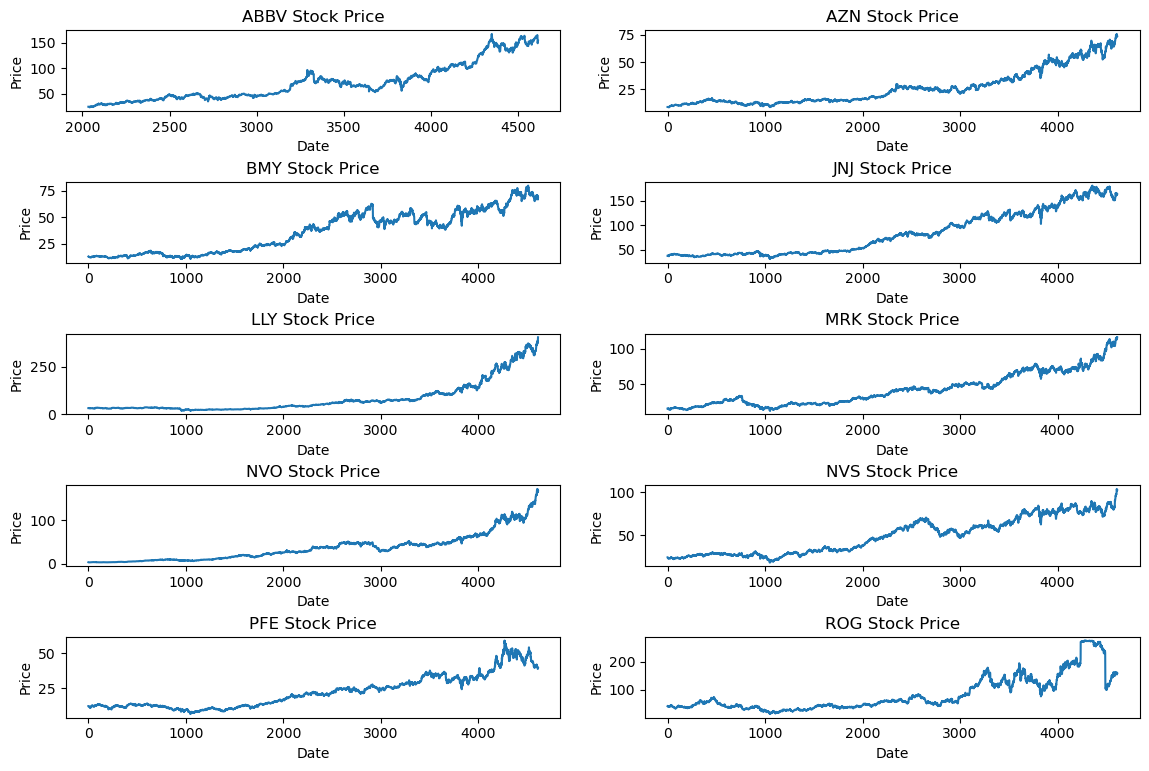

In [7]:

prices_wide_plot = prices_wide.drop('Date', axis=1)

# Get the number of stocks
num_stocks = len(prices_wide_plot.columns)

# Calculate the number of rows and columns for subplots
num_rows = int(num_stocks / 2)  # Divide by 2 for two columns
num_cols = 2  # Two columns

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
fig.tight_layout(pad=3.0)  # Add some padding between subplots

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over each stock and plot its time series on a subplot
for i, column in enumerate(prices_wide_plot.columns):
    # Select the current subplot
    ax = axes[i]

    # Plot the stock's time series on the current subplot
    ax.plot(prices_wide_plot[column])

    # Set the title and labels for the current subplot
    ax.set_title(f"{column} Stock Price")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")

# Remove any unused subplots
if num_stocks < len(axes):
    for j in range(num_stocks, len(axes)):
        fig.delaxes(axes[j])

# Display the plot
plt.show()


In [8]:
prices_wide.head()

Ticker,Date,ABBV,AZN,BMY,JNJ,LLY,MRK,NVO,NVS,PFE,ROG
0,2005-01-03,NaN,8.583023,12.840363,37.560474,31.251883,15.251282,3.775994,23.981447,12.258106,42.500000
1,2005-01-04,NaN,8.561698,12.698970,37.441021,30.835196,15.187860,3.651316,23.399443,12.258106,42.160000
2,2005-01-05,NaN,8.530893,12.658134,37.417137,31.157429,15.290318,3.615692,23.308805,12.174684,41.950001
3,2005-01-06,NaN,8.580654,12.637698,37.524632,31.407444,15.397648,3.709023,23.180000,12.183954,41.700001
4,2005-01-07,NaN,8.644635,12.632594,37.387295,31.257429,15.187860,3.726122,22.922390,12.188584,41.299999


Also keeping price in long format, will be easier to add other covariates with the data in this format

In [9]:
columns_keep = ['Date', 'Adj Close', 'Volume', 'Ticker']
prices_long = prices[columns_keep]
prices_long.head()

,Date,Adj Close,Volume,Ticker
0,2013-02-01,24.526785,9527500,ABBV
1,2013-02-04,24.592743,6348000,ABBV
2,2013-02-05,24.539970,7284400,ABBV
3,2013-02-06,24.500391,5738900,ABBV
4,2013-02-07,24.025429,9872500,ABBV


In [10]:
#it's the variable that starts later
prices_long[prices_long['Ticker'] == 'ABBV']['Date'].min()

'2013-02-01'

In [11]:
# Convert 'Date' column to DateTime index
prices_long['Date'] = pd.to_datetime(prices_long['Date'])
prices_long.set_index(['Date', 'Ticker'], inplace=True)

prices_long.head()

/tmp/ipykernel_9574/4024555779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_long['Date'] = pd.to_datetime(prices_long['Date'])


,,Adj Close,Volume
Date,Ticker,,
2013-02-01,ABBV,24.526785,9527500
2013-02-04,ABBV,24.592743,6348000
2013-02-05,ABBV,24.539970,7284400
2013-02-06,ABBV,24.500391,5738900
2013-02-07,ABBV,24.025429,9872500


### Creating some variables

10 days close percentual (future and past)


In [12]:
# 10d past return %
prices_long['10d_close_pct'] = prices_long['Adj Close'].pct_change(10)
prices_long['10d_future_close'] = prices_long['Adj Close'].shift(-10)
prices_long['10d_future_close_pct'] = prices_long['10d_future_close'].pct_change(10)

# this code creates the Moving Average and RSI (Relative Strenght Index) for the stocks in different time windows 
time_periods = [5, 14, 50, 200]
for n in time_periods:
    prices_long[f'ma{n}'] = talib.SMA(prices_long['Adj Close'].values, timeperiod=n)
    prices_long[f'rsi{n}'] = talib.RSI(prices_long['Adj Close'].values, timeperiod=n)



/tmp/ipykernel_9574/1095230260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_long['10d_close_pct'] = prices_long['Adj Close'].pct_change(10)
/tmp/ipykernel_9574/1095230260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_long['10d_future_close'] = prices_long['Adj Close'].shift(-10)
/tmp/ipykernel_9574/1095230260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [13]:
prices_long = prices_long.dropna() #dropping NAs we still have a lot of information

In [14]:
#adding the ec10 info
import topicmodelutils

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/djtom/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/djtom/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/djtom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/djtom/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


sales exists in the following rows:
514

revenue exists in the following rows:
456

top line exists in the following rows:
320



In [58]:
ec=topicmodelutils.topicdictcount.copy()

In [61]:
ec.date=pd.to_datetime(ec.date)
ec.drop(['index','result'], axis=1, inplace=True)
ec.set_index(['date', 'symbol'], inplace=True)
ec.index.names=['Date', 'Ticker']
test_merge=ec.merge(prices_long, left_index=True, right_index=True, how='outer')
test_merge=test_merge[test_merge['content'].notna()].sort_values(['Ticker','Date'])
test_merge=test_merge.groupby('Ticker').ffill()
# test_merge[test_merge.index.get_level_values('Ticker').isin(['ABBV'])].head(3)

In [89]:
test_merge.dropna(inplace=True)
test_merge.describe()

,quarter,year,topic0,topic1,topic2,topic4,topic5,topic3,t1,t2,...,10d_future_close,10d_future_close_pct,ma5,rsi5,ma14,rsi14,ma50,rsi50,ma200,rsi200
count,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,...,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000
mean,2.523438,2014.589844,0.228396,0.124426,0.130546,0.112842,0.328472,0.072503,0.074993,0.017145,...,52.638981,0.005571,52.178999,51.308885,51.996996,52.443304,51.514789,52.659103,49.459331,51.967888
std,1.115378,4.219484,0.269986,0.162573,0.155996,0.168968,0.230845,0.172759,0.033524,0.012098,...,38.532967,0.044722,37.728129,24.313796,37.261609,13.890790,36.796654,6.601793,34.044476,3.642504
min,1.000000,2005.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006912,0.000000,...,8.122423,-0.235928,7.497709,3.690605,7.635450,14.466953,7.628865,31.988542,8.541862,36.253669
25%,2.000000,2011.000000,0.052848,0.007512,0.027334,0.018147,0.145491,0.000000,0.050286,0.007964,...,25.896771,-0.020754,25.912387,30.259930,25.728666,41.947171,25.727026,48.342138,25.203927,50.148796
50%,3.000000,2015.000000,0.101952,0.038951,0.082104,0.050725,0.249625,0.011608,0.071429,0.014334,...,43.274546,0.003789,43.198604,49.491133,43.225822,52.282883,42.966493,52.860358,42.224030,52.053105
75%,4.000000,2018.000000,0.235468,0.219418,0.162341,0.138640,0.485788,0.038216,0.096044,0.023734,...,65.447481,0.030935,64.565353,73.677192,64.985730,62.876048,64.381921,56.761373,61.928277,54.266488
max,4.000000,2021.000000,0.928711,0.650248,0.710558,0.941608,0.898324,0.756952,0.209726,0.085714,...,267.297485,0.163807,242.767819,97.375888,239.603727,88.194148,251.424514,75.982581,234.335066,65.648458


In [90]:
prices_long=test_merge.copy()

In [91]:
# generating train and test datasets
train_df = prices_long[prices_long.index.get_level_values('Date') <= '2020-12-31']
test_df = prices_long[prices_long.index.get_level_values('Date') > '2020-12-31']

In [92]:
# generating the dataset for the classification task

train_df_class = train_df.copy()
test_df_class = test_df.copy()

train_df_class['10d_future_close_pct'] = np.where(train_df_class['10d_future_close_pct'] > 0.02, 'UP',
                          np.where(train_df_class['10d_future_close_pct'] < -0.02, 'DOWN', 'STAY'))
test_df_class['10d_future_close_pct'] = np.where(test_df_class['10d_future_close_pct'] > 0.02, 'UP',
                          np.where(test_df_class['10d_future_close_pct'] < -0.02, 'DOWN', 'STAY'))



### Parameters

Defining the metrics for evaluation of the models

In [93]:
# metric = 'rmse'

## 1.Linear Models

### Model 1.1 Linear model with price and volume only

#### 1.1.1 Regression

In [94]:
# defining features and targte for this model
features = ['Volume', '10d_close_pct']
target = '10d_future_close_pct' #since the task is predict return we will put the return and not the price as feature

# defining train and test set for this model
train_features, train_targets = train_df[features], train_df[target]
test_features, test_targets = test_df[features], test_df[target]

In [95]:
# Add a constant to the features
train_features = sm.add_constant(train_features)
test_features = sm.add_constant(test_features)

# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                             
Dep. Variable:     10d_future_close_pct   R-squared:                       0.002
Model:                              OLS   Adj. R-squared:                 -0.002
Method:                   Least Squares   F-statistic:                    0.4793
Date:                  Mon, 15 May 2023   Prob (F-statistic):              0.620
Time:                          18:16:37   Log-Likelihood:                 787.10
No. Observations:                   464   AIC:                            -1568.
Df Residuals:                       461   BIC:                            -1556.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0045  

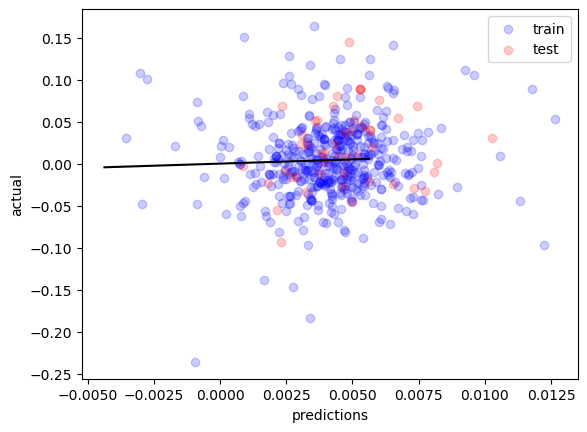

In [96]:
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

#### 1.1.2 Classification

In [97]:
# defining features and targte for this model
features = ['Volume', '10d_close_pct']
target = '10d_future_close_pct' #since the task is predict return we will put the return and not the price as feature

# defining train and test set for this model
train_features, train_targets = train_df_class[features], train_df_class[target]
test_features, test_targets = test_df_class[features], test_df_class[target]

In [98]:

# Create and fit the logistic regression model
logreg = LogisticRegression()
logreg.fit(train_features, train_targets)

# Make predictions from the logistic regression model
train_predictions = logreg.predict(train_features)
test_predictions = logreg.predict(test_features)

# Print classification report for train and test sets
print("Train Set Classification Report:")
print(classification_report(train_targets, train_predictions))
print("Test Set Classification Report:")
print(classification_report(test_targets, test_predictions))


Train Set Classification Report:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00       122
        STAY       0.40      1.00      0.57       187
          UP       0.00      0.00      0.00       155

    accuracy                           0.40       464
   macro avg       0.13      0.33      0.19       464
weighted avg       0.16      0.40      0.23       464

Test Set Classification Report:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00        10
        STAY       0.29      1.00      0.45        14
          UP       0.00      0.00      0.00        24

    accuracy                           0.29        48
   macro avg       0.10      0.33      0.15        48
weighted avg       0.09      0.29      0.13        48



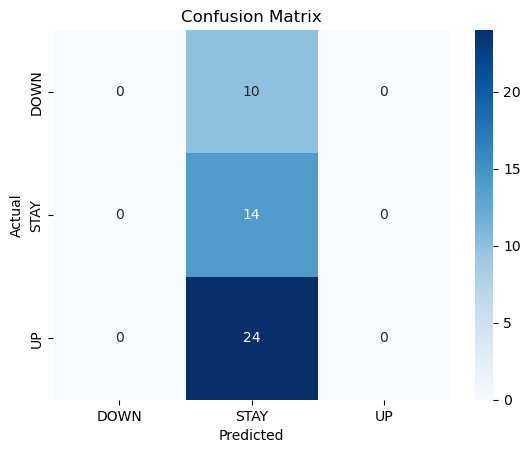

In [99]:
# Calculate confusion matrix
cm = confusion_matrix(test_targets, test_predictions)

# Get the unique labels from the actual variable
labels = np.unique(test_targets)

# Plot confusion matrix as a heatmap with labels
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Model 1.2 Linear model with price, volume and other technical indicators data

#### 1.2.1 Regression

In [100]:
# defining features and targte for this model
features = [ 'Volume', '10d_close_pct', 'ma5', 'rsi5', 
            'ma14', 'rsi14', 'ma50', 'rsi50','ma200', 'rsi200']
target = '10d_future_close_pct' #since the task is predict return we will put the return and not the price as feature

# defining train and test set for this model
train_features, train_targets = train_df[features], train_df[target]
test_features, test_targets = test_df[features], test_df[target]

In [101]:
# Add a constant to the features
train_features = sm.add_constant(train_features)
test_features = sm.add_constant(test_features)

# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                             
Dep. Variable:     10d_future_close_pct   R-squared:                       0.048
Model:                              OLS   Adj. R-squared:                  0.027
Method:                   Least Squares   F-statistic:                     2.298
Date:                  Mon, 15 May 2023   Prob (F-statistic):             0.0123
Time:                          18:22:09   Log-Likelihood:                 798.10
No. Observations:                   464   AIC:                            -1574.
Df Residuals:                       453   BIC:                            -1529.
Df Model:                            10                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0215  

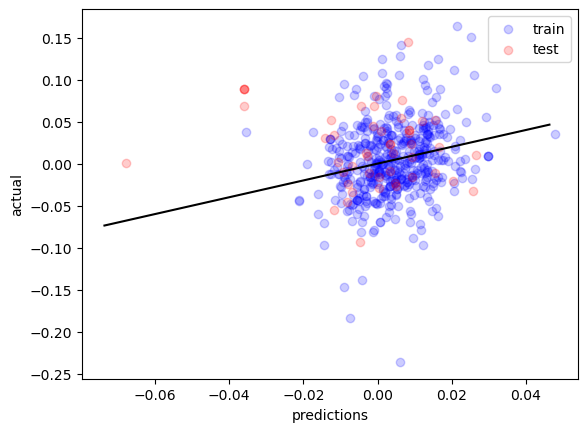

In [102]:
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

#### 1.2.2 Classification

In [103]:
# defining features and targte for this model
features = [ 'Volume', '10d_close_pct', 'ma5', 'rsi5', 
            'ma14', 'rsi14', 'ma50', 'rsi50','ma200', 'rsi200']
target = '10d_future_close_pct' #since the task is predict return we will put the return and not the price as feature

# defining train and test set for this model
train_features, train_targets = train_df_class[features], train_df_class[target]
test_features, test_targets = test_df_class[features], test_df_class[target]

In [104]:

# Create and fit the logistic regression model
logreg = LogisticRegression()
logreg.fit(train_features, train_targets)

# Make predictions from the logistic regression model
train_predictions = logreg.predict(train_features)
test_predictions = logreg.predict(test_features)

# Print classification report for train and test sets
print("Train Set Classification Report:")
print(classification_report(train_targets, train_predictions))
print("Test Set Classification Report:")
print(classification_report(test_targets, test_predictions))

Train Set Classification Report:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00       122
        STAY       0.40      1.00      0.57       187
          UP       0.00      0.00      0.00       155

    accuracy                           0.40       464
   macro avg       0.13      0.33      0.19       464
weighted avg       0.16      0.40      0.23       464

Test Set Classification Report:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00        10
        STAY       0.29      1.00      0.45        14
          UP       0.00      0.00      0.00        24

    accuracy                           0.29        48
   macro avg       0.10      0.33      0.15        48
weighted avg       0.09      0.29      0.13        48



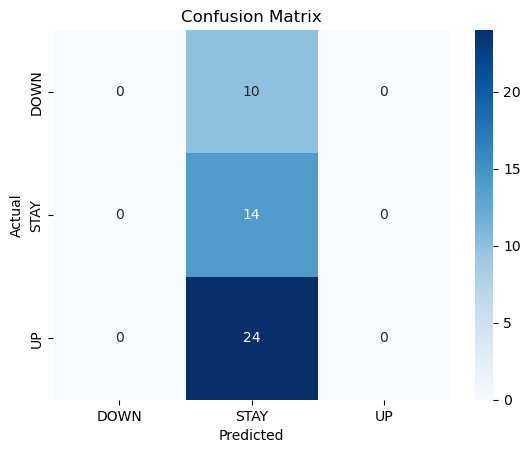

In [105]:
# Calculate confusion matrix
cm = confusion_matrix(test_targets, test_predictions)

# Get the unique labels from the actual variable
labels = np.unique(test_targets)

# Plot confusion matrix as a heatmap with labels
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Model 1.3 Linear model with price, volume, technical indicators data and balance sheet data

### Model 1.4 Linear model with price, volume, technical indicators, balance sheet data and text features

#### 1.2.1 Regression

In [106]:
train_df.columns

Index(['quarter', 'year', 'content', 'topic0', 'topic1', 'topic2', 'topic4',
       'topic5', 'topic3', 't1', 't2', 't3', 't4', 't5', 't6', 't1d', 't2d',
       't3d', 't4d', 't5d', 't6d', 't1dg', 't2dg', 't3dg', 't4dg', 't5dg',
       't6dg', 'Adj Close', 'Volume', '10d_close_pct', '10d_future_close',
       '10d_future_close_pct', 'ma5', 'rsi5', 'ma14', 'rsi14', 'ma50', 'rsi50',
       'ma200', 'rsi200'],
      dtype='object')

Adding textual features from topic modeling using LDA.

                             OLS Regression Results                             
Dep. Variable:     10d_future_close_pct   R-squared:                       0.074
Model:                              OLS   Adj. R-squared:                  0.041
Method:                   Least Squares   F-statistic:                     2.230
Date:                  Mon, 15 May 2023   Prob (F-statistic):            0.00416
Time:                          18:41:22   Log-Likelihood:                 804.44
No. Observations:                   464   AIC:                            -1575.
Df Residuals:                       447   BIC:                            -1504.
Df Model:                            16                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7434  

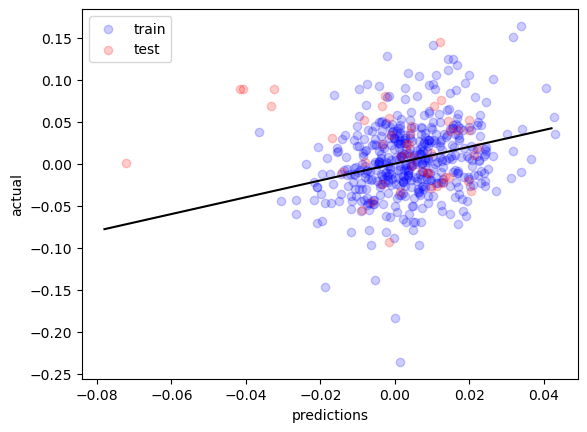

In [113]:
# defining features and targte for this model
features = [ 'Volume', '10d_close_pct', 'ma5', 'rsi5', 
            'ma14', 'rsi14', 'ma50', 'rsi50','ma200', 'rsi200']+['topic0','topic1','topic2','topic3', 'topic4','topic5']
target = '10d_future_close_pct' #since the task is predict return we will put the return and not the price as feature

# defining train and test set for this model
train_features, train_targets = train_df[features], train_df[target]
test_features, test_targets = test_df[features], test_df[target]
# Add a constant to the features
train_features = sm.add_constant(train_features)
test_features = sm.add_constant(test_features)

# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

Adding topic tagging with directional tags-features instead.

                             OLS Regression Results                             
Dep. Variable:     10d_future_close_pct   R-squared:                       0.063
Model:                              OLS   Adj. R-squared:                  0.030
Method:                   Least Squares   F-statistic:                     1.893
Date:                  Mon, 15 May 2023   Prob (F-statistic):             0.0193
Time:                          18:41:33   Log-Likelihood:                 801.83
No. Observations:                   464   AIC:                            -1570.
Df Residuals:                       447   BIC:                            -1499.
Df Model:                            16                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0275  

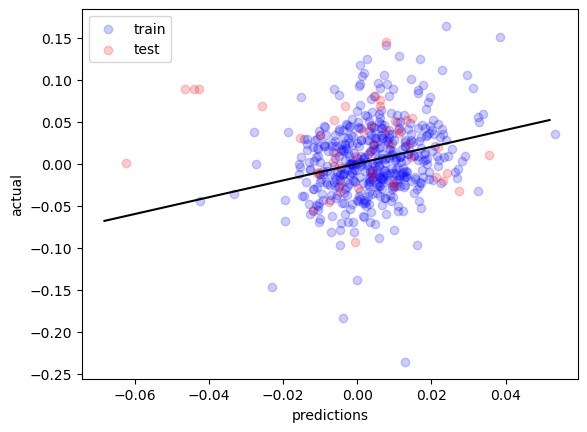

In [114]:
# defining features and targte for this model
features = [ 'Volume', '10d_close_pct', 'ma5', 'rsi5', 
            'ma14', 'rsi14', 'ma50', 'rsi50','ma200', 'rsi200']+[ 't1dg', 't2dg', 't3dg', 't4dg', 't5dg', 't6dg']
target = '10d_future_close_pct' #since the task is predict return we will put the return and not the price as feature

# defining train and test set for this model
train_features, train_targets = train_df[features], train_df[target]
test_features, test_targets = test_df[features], test_df[target]
# Add a constant to the features
train_features = sm.add_constant(train_features)
test_features = sm.add_constant(test_features)

# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

#### 1.3.2 Classification

## 2.Machine Learning models

In [116]:
# we could also add interaction terms and see how they perform
# defining features and targte for this model
features = [ 'Volume', '10d_close_pct', 'ma5', 'rsi5', 
            'ma14', 'rsi14', 'ma50', 'rsi50','ma200', 'rsi200']
target = '10d_future_close_pct' #since the task is predict return we will put the return and not the price as feature

# defining train and test set for this model
train_features, train_targets = train_df[features], train_df[target]
test_features, test_targets = test_df[features], test_df[target]

In [117]:
SEED = 2000
# models
models = [
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          AdaBoostRegressor(),
         GradientBoostingRegressor()
         ]

# models parameters

dectree_params = {'max_features': range(4, 10),
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

randomforest_params = {'max_features': range(4, 10),
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

adab_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'loss':['linear', 'square'],
                  'random_state': [SEED]}

gb_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                'max_features': range(4, 10),
                  'random_state': [SEED]}

params = [ dectree_params, randomforest_params, adab_params, gb_params]
names = ['DecisionTree_Regressor', 'RandomForest_Regressor', 'AdaBoost_Regressor',
        'GradientBoosting_Regressor']
scores = {}

# gridsearch
for i, model in enumerate(models):
    print(f"Grid-Searching for model {names[i]}...")
    best_model = HalvingGridSearchCV(model, params[i], n_jobs=4, cv=5, 
                              scoring='r2', verbose = 0) #using R2 as metric for scoring
    best_model.fit(train_features, train_targets)
    print(f"Best model fitted")
    #assign the best parameters to my models
    models[i].set_params(**best_model.best_params_)

    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
    print(f'{names[i]} R2 score on train sample: {-best_model.best_score_}')

Grid-Searching for model DecisionTree_Regressor...


/home/djtom/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/djtom/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/djtom/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/djtom/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/djtom/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:91

Best model fitted
DecisionTree_Regressor chosen hyperparameters: {'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 9, 'random_state': 2000}
DecisionTree_Regressor R2 score on train sample: 0.16348465990077443
Grid-Searching for model RandomForest_Regressor...


/home/djtom/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/djtom/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/djtom/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/djtom/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/djtom/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:91

Best model fitted
RandomForest_Regressor chosen hyperparameters: {'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 9, 'n_estimators': 100, 'random_state': 2000}
RandomForest_Regressor R2 score on train sample: 0.050331857985241604
Grid-Searching for model AdaBoost_Regressor...
Best model fitted
AdaBoost_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 100, 'random_state': 2000}
AdaBoost_Regressor R2 score on train sample: 0.03972218004165917
Grid-Searching for model GradientBoosting_Regressor...
Best model fitted
GradientBoosting_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 6, 'n_estimators': 50, 'random_state': 2000}
GradientBoosting_Regressor R2 score on train sample: 0.09066195792025593


In [118]:
#printing the best model
best_model

HalvingGridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.05,
                                                        max_features=6,
                                                        n_estimators=50,
                                                        random_state=2000),
                    n_jobs=4,
                    param_grid={'learning_rate': [0.05, 1],
                                'max_depth': range(3, 6),
                                'max_features': range(4, 10),
                                'n_estimators': [50, 100],
                                'random_state': [2000]},
                    scoring='r2')

In [119]:
# getting the predictions for the best model
train_predictions = best_model.predict(train_features)
test_predictions = best_model.predict(test_features)

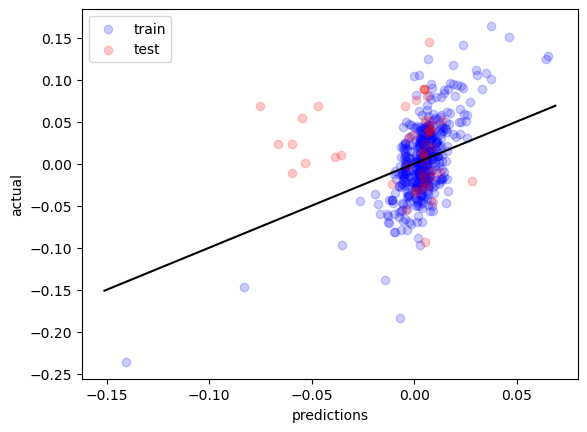

In [120]:
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

### Model 2.1 ML model with price, volume and other technical indicators data

### Model 2.2 ML model with price, volume, technical indicators data and balance sheet data

### Model 2.3 ML model with price, volume, technical indicators, balance sheet data and text features

Grid-Searching for model DecisionTree_Regressor...


/home/djtom/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/djtom/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/djtom/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/djtom/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/djtom/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:91

Best model fitted
DecisionTree_Regressor chosen hyperparameters: {'max_depth': 3, 'max_features': 9, 'min_samples_leaf': 8, 'random_state': 2000}
DecisionTree_Regressor R2 score on train sample: 0.1030443092786761
Grid-Searching for model RandomForest_Regressor...


/home/djtom/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/djtom/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/djtom/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/djtom/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/djtom/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:91

Best model fitted
RandomForest_Regressor chosen hyperparameters: {'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 9, 'n_estimators': 100, 'random_state': 2000}
RandomForest_Regressor R2 score on train sample: 0.03410423172062824
Grid-Searching for model AdaBoost_Regressor...
Best model fitted
AdaBoost_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 50, 'random_state': 2000}
AdaBoost_Regressor R2 score on train sample: 0.012858833390436964
Grid-Searching for model GradientBoosting_Regressor...
Best model fitted
GradientBoosting_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 4, 'n_estimators': 50, 'random_state': 2000}
GradientBoosting_Regressor R2 score on train sample: 0.07884077682490387


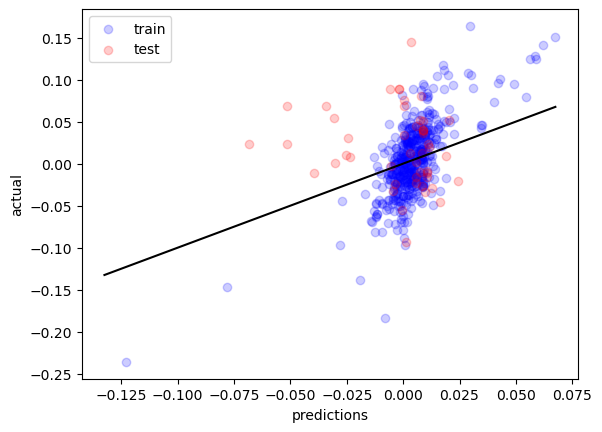

In [115]:
# we could also add interaction terms and see how they perform
# defining features and targte for this model
features = [ 'Volume', '10d_close_pct', 'ma5', 'rsi5', 
            'ma14', 'rsi14', 'ma50', 'rsi50','ma200', 'rsi200']+['topic0','topic1','topic2','topic3', 'topic4','topic5']
target = '10d_future_close_pct' #since the task is predict return we will put the return and not the price as feature

# defining train and test set for this model
train_features, train_targets = train_df[features], train_df[target]
test_features, test_targets = test_df[features], test_df[target]
SEED = 2000
# models
models = [
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          AdaBoostRegressor(),
         GradientBoostingRegressor()
         ]

# models parameters

dectree_params = {'max_features': range(4, 10),
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

randomforest_params = {'max_features': range(4, 10),
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

adab_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'loss':['linear', 'square'],
                  'random_state': [SEED]}

gb_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                'max_features': range(4, 10),
                  'random_state': [SEED]}

params = [ dectree_params, randomforest_params, adab_params, gb_params]
names = ['DecisionTree_Regressor', 'RandomForest_Regressor', 'AdaBoost_Regressor',
        'GradientBoosting_Regressor']
scores = {}

# gridsearch
for i, model in enumerate(models):
    print(f"Grid-Searching for model {names[i]}...")
    best_model = HalvingGridSearchCV(model, params[i], n_jobs=4, cv=5, 
                              scoring='r2', verbose = 0) #using R2 as metric for scoring
    best_model.fit(train_features, train_targets)
    print(f"Best model fitted")
    #assign the best parameters to my models
    models[i].set_params(**best_model.best_params_)

    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
    print(f'{names[i]} R2 score on train sample: {-best_model.best_score_}')
#printing the best model
best_model
# getting the predictions for the best model
train_predictions = best_model.predict(train_features)
test_predictions = best_model.predict(test_features)
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()